# Running FaIR

We will run FaIR using an SR1.5-like setup, with a few changes to reflect our updated knowledge. In SR1.5 we used v1.3.4 but the interface and setup will work exactly the same in v1.6.2.

In [1]:
import glob
from multiprocessing import Pool
import os
import sys

from climateforcing.utils import check_and_download
import matplotlib.pyplot as pl
import fair
from fair.forward import fair_scm
from fair.tools.magicc import scen_open
from fair.ancil import cmip6_solar, cmip6_volcanic, natural
from fair.RCPs import rcp3pd, rcp45
from fair.constants import lifetime
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scmdata.run import ScmRun, run_append
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [2]:
fair.__version__

'1.6.2'

## Get FaIR SR1.5 config

A 10,000 member ensemble, trimmed down from a larger prior, is provided. This is the first 10,000 members of the large ensemble produced for [Smith et al. 2018](https://gmd.copernicus.org/articles/11/2273/2018/). 10,000 gives us around about 500-600 after constraining, which is why we use this number.

Here, we are going to constrain the 10,000 based on how well they reproduce temperature and CO2 concentrations in RCP4.5 until 2019.

In [3]:
config_dir = 'fair_sr15_params/'
ecstcr = np.load(config_dir+'ecstcr_recalc.npy')
d1 = np.load(config_dir+'d1_samples.npy')
d2 = np.load(config_dir+'d2_samples.npy')
rscale = np.load(config_dir+'r_samples.npy')
scale = np.load(config_dir+'forcing_scalings.npy')

### Other data sources and constants

In [4]:
avi = rcp3pd.aviNOx_frac
ch4 = rcp3pd.fossilCH4_frac
nat = natural.Emissions.emissions
efficacy = np.ones(13); efficacy[9] = 3.0
sol = np.zeros((2501-1765))
sol[:254] = cmip6_solar.Forcing.solar[:254]
vol = np.zeros((2501-1765))
vol[:254] = cmip6_volcanic.Forcing.volcanic[:254]
tcr_dbl = np.log(2.0)/np.log(1.01)

In [5]:
check_and_download(
    'https://github.com/chrisroadmap/ar6/raw/main/data_input/observations/AR6%20FGD%20assessment%20time%20series%20-%20GMST%20and%20GSAT.xlsx',
    'data/ar6_temperatures.xlsx'
)

In [6]:
temp_df = pd.read_excel('data/ar6_temperatures.xlsx', skiprows=1)
temp_gmst = temp_df['4-set mean'][:170].values

## Get scenarios

In [7]:
scen_file_dir = 'scen_files'
scens_to_run = [
    x for x in os.listdir(scen_file_dir) 
    if x.endswith('.SCEN') and 'BAU' not in x and 'STEPS' not in x
]
scens_to_run

['bp_Net_Zero_eqw.SCEN',
 'bp_Net_Zero_qrw.SCEN',
 'bp_Net_Zero_rms.SCEN',
 'bp_Rapid_eqw.SCEN',
 'bp_Rapid_qrw.SCEN',
 'bp_Rapid_rms.SCEN',
 'equinor_Rebalance_eqw.SCEN',
 'equinor_Rebalance_qrw.SCEN',
 'equinor_Rebalance_rms.SCEN',
 'ieasr15_NZ2021_eqw.SCEN',
 'ieasr15_NZ2021_qrw.SCEN',
 'ieasr15_NZ2021_rms.SCEN',
 'shell_sky_eqw.SCEN',
 'shell_sky_qrw.SCEN',
 'shell_sky_rms.SCEN',
 'weo_SDS_2020_eqw.SCEN',
 'weo_SDS_2020_qrw.SCEN',
 'weo_SDS_2020_rms.SCEN']

In [8]:
scens_to_run = (
    [os.path.join(scen_file_dir, s) for s in scens_to_run] 
)
scens_to_run

['scen_files\\bp_Net_Zero_eqw.SCEN',
 'scen_files\\bp_Net_Zero_qrw.SCEN',
 'scen_files\\bp_Net_Zero_rms.SCEN',
 'scen_files\\bp_Rapid_eqw.SCEN',
 'scen_files\\bp_Rapid_qrw.SCEN',
 'scen_files\\bp_Rapid_rms.SCEN',
 'scen_files\\equinor_Rebalance_eqw.SCEN',
 'scen_files\\equinor_Rebalance_qrw.SCEN',
 'scen_files\\equinor_Rebalance_rms.SCEN',
 'scen_files\\ieasr15_NZ2021_eqw.SCEN',
 'scen_files\\ieasr15_NZ2021_qrw.SCEN',
 'scen_files\\ieasr15_NZ2021_rms.SCEN',
 'scen_files\\shell_sky_eqw.SCEN',
 'scen_files\\shell_sky_qrw.SCEN',
 'scen_files\\shell_sky_rms.SCEN',
 'scen_files\\weo_SDS_2020_eqw.SCEN',
 'scen_files\\weo_SDS_2020_qrw.SCEN',
 'scen_files\\weo_SDS_2020_rms.SCEN']

In [9]:
emissions = {}
scen_labels = []
nscen = len(scens_to_run)

for scen in scens_to_run:
    name = os.path.split(scen)[1][:-5]
    scen_labels.append(name)
    emissions[name] = scen_open(scen)

## Sense check emissions plots

the purple one looks a bit odd - does MAGICC show this too?

Otherwise, the harmonization looks fine.

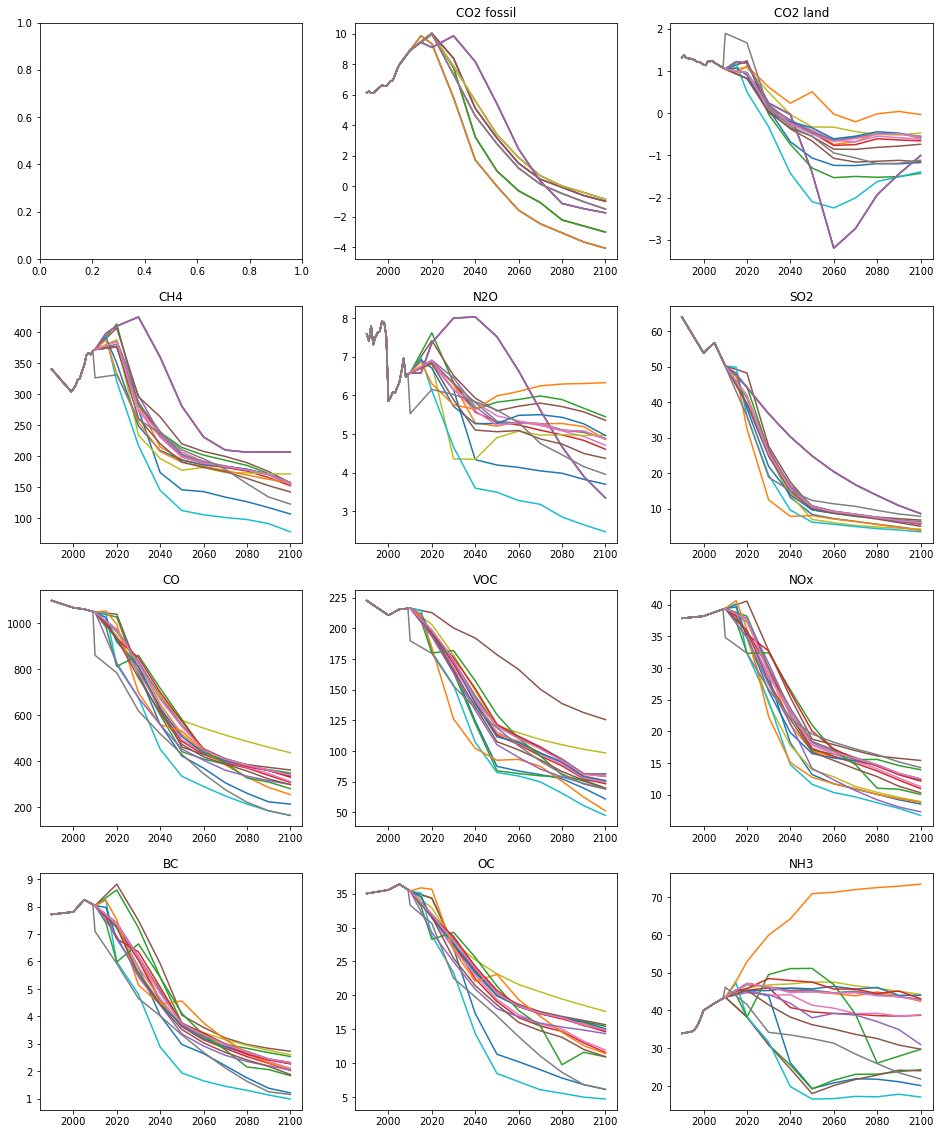

In [10]:
species = {
    1 : 'CO2 fossil',
    2 : 'CO2 land',
    3 : 'CH4',
    4 : 'N2O',
    5 : 'SO2',
    6 : 'CO',
    7 : 'VOC',
    8 : 'NOx',
    9 : 'BC',
    10 : 'OC',
    11 : 'NH3'
}

fig, ax = pl.subplots(4, 3, figsize=(16, 20))

for ispec, specie in species.items():
    row = ispec//3
    col = ispec%3
    for scen in scen_labels:
        ax[row, col].plot(np.arange(1990, 2101), emissions[scen][225:, ispec])
    ax[row, col].set_title(specie)

## Run 10,000 member ensemble in RCP4.5 for constraining

Constrain the results on both present-day CO2 concentrations assuming RCP4.5 emissions, and temperature.

In [11]:
endyear = 2019
nt = endyear - 1765 + 1
n = 10000
Fscale = np.ones(13)
C = np.zeros((nt, n))
T = np.zeros((nt, n))
for ens in tqdm(range(n)):
    Fscale[1:12] = scale[ens,1:12]
    thisC, _, T[:, ens] = fair_scm(
        emissions = rcp45.Emissions.emissions[:nt, :],
        tcrecs = ecstcr[ens,::-1],
        F_volcanic = vol[:nt],
        F_solar = sol[:nt]+scale[ens,12],
        natural = nat[:nt,:],
        r0 = 35.0*rscale[ens,0],
        rt = 4.165*rscale[ens,1],
        rc = 0.019*rscale[ens,2],
        d = np.array([d2[ens], d1[ens]]),
        F2x = 3.71 * scale[ens,0],
        scale = Fscale,
        tcr_dbl = tcr_dbl,
        aviNOx_frac = avi[:nt],
        fossilCH4_frac = ch4[:nt],
        efficacy = efficacy,
        scaleHistoricalAR5 = False,
    )
    C[:, ens] = thisC[:, 0]

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\smithc\Anaconda3\envs\institutional_scenarios\lib\site-packages\fair\gas_cycle\fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [12]:
# IPCC 2021 gives 2019 CO2 concentrations as 409.85 ppm
# we will allow +/- 2 ppm around this
accept_co2 = ((407.85 < C[-1, :]) & (C[-1, :] < 411.85))
valid_co2 = np.arange(n, dtype=int)[accept_co2]
np.sum(accept_co2)

1560

In [13]:
# temperatures: follow IPCC AR6 constraining method
def rmse(obs, mod):
    return np.sqrt(np.sum((obs-mod)**2)/len(obs))

rmse_temp = np.zeros((n))
for i in range(n):
    rmse_temp[i] = rmse(temp_gmst, (T[85:255,i]-np.mean(T[85:136,i], axis=0)))
accept_temp=(rmse_temp<0.135)
valid_temp = np.arange(n, dtype=int)[accept_temp]
print(np.sum(accept_temp))

2486


In [14]:
# this number of ensemble members pass both constraints
valid = np.arange(n, dtype=int)[(accept_temp & accept_co2)]
np.sum(accept_temp & accept_co2)

505

## Run constrained ensemble for each scenario

In [15]:
T_result = {}

endyear = 2100
nt = endyear - 1765 + 1
for scen in tqdm(scen_labels):
    Fscale = np.ones(13)
    T_result[scen] = np.zeros((nt, len(valid)))
    for i, ens in tqdm(enumerate(valid), total=len(valid), leave=False, position=0):
        Fscale[1:12] = scale[ens,1:12]
        _, _, thisT = fair_scm(emissions[scen],
            tcrecs         = ecstcr[ens,::-1],
            F_volcanic     = vol[:nt],
            F_solar        = sol[:nt]+scale[ens,12],
            natural        = nat[:nt,:],
            r0             = 35.0*rscale[ens,0],
            rt             = 4.165*rscale[ens,1],
            rc             = 0.019*rscale[ens,2],
            d              = np.array([d2[ens], d1[ens]]),
            F2x            = 3.71 * scale[ens,0],
            scale          = Fscale,
            tcr_dbl        = tcr_dbl,
            aviNOx_frac    = avi[:nt],
            fossilCH4_frac = ch4[:nt],
            efficacy       = efficacy,
            scaleHistoricalAR5=False,
        )
        T_result[scen][:,i]      = thisT

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

In [16]:
pl.fill_between(
    np.arange(1850, 2101),
    np.percentile(T_result['bp_Net_Zero_eqw'] - T_result['bp_Net_Zero_eqw'][230:250, :].mean(axis=0) + 0.85, 5, axis=1)[85:],
    np.percentile(T_result['bp_Net_Zero_eqw'] - T_result['bp_Net_Zero_eqw'][230:250, :].mean(axis=0) + 0.85, 95, axis=1)[85:]
)
pl.plot(np.arange(1850, 2101), np.median(T_result['bp_Net_Zero_eqw'] - T_result['bp_Net_Zero_eqw'][230:250, :].mean(axis=0) + 0.85, axis=1)[85:], color='k');
pl.plot(np.arange(1850, 2020), temp_gmst-temp_gmst[145:165].mean() + 0.85, color='r')

In [17]:
pl.plot(T_result['bp_Net_Zero_eqw']);

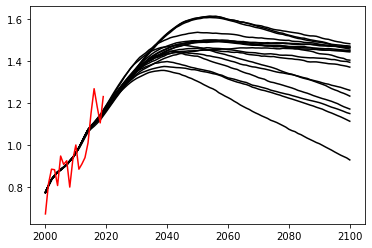

In [18]:
# median projection from each scenario
for scen in scen_labels:
    pl.plot(np.arange(2000, 2101), np.median(T_result[scen] - T_result[scen][230:250, :].mean(axis=0) + 0.85, axis=1)[235:], color='k');
pl.plot(np.arange(2000, 2020), temp_gmst[150:]-temp_gmst[145:165].mean() + 0.85, color='r')

## Save the results

In [19]:
VARIABLES = ["Surface Temperature"]
UNITS = ["K"]

In [20]:
def new_timeseries(
    data,
    n=100,
    climate_model="FaIRv%s" % fair.__version__,
    model='unspecified',
    scenario="unspecified",
    variable="unspecified",
    unit="unspecified",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    index = 1765 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "climate_model": climate_model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

In [21]:
all_runs = []
for scen in scen_labels:
    for i in range(len(valid)):
        all_runs.append(
            new_timeseries(
                (T_result[scen][:,i] - T_result[scen][230:250,i].mean(axis=0) + 0.85).T,
                n=T_result[scen].shape[0],
                scenario=scen,
                variable=VARIABLES,
                unit=UNITS,
                ensemble_member=i,
            )
        )

In [22]:
runs = run_append(all_runs)

In [23]:
runs 

<scmdata.ScmRun (timeseries: 9090, timepoints: 336)>
Time:
	Start: 1765-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     climate_model  ensemble_member        model region          scenario  \
	0       FaIRv1.6.2                0  unspecified  World   bp_Net_Zero_eqw   
	1       FaIRv1.6.2                1  unspecified  World   bp_Net_Zero_eqw   
	2       FaIRv1.6.2                2  unspecified  World   bp_Net_Zero_eqw   
	3       FaIRv1.6.2                3  unspecified  World   bp_Net_Zero_eqw   
	4       FaIRv1.6.2                4  unspecified  World   bp_Net_Zero_eqw   
	...            ...              ...          ...    ...               ...   
	9085    FaIRv1.6.2              500  unspecified  World  weo_SDS_2020_rms   
	9086    FaIRv1.6.2              501  unspecified  World  weo_SDS_2020_rms   
	9087    FaIRv1.6.2              502  unspecified  World  weo_SDS_2020_rms   
	9088    FaIRv1.6.2              503  unspecified  World  weo_SDS_2020_rms   
	9089    FaIRv1.6.2    

In [24]:
runs.timeseries()

time                                                                                        1765-01-01  \
climate_model ensemble_member model       region scenario         unit variable                          
FaIRv1.6.2    0               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature    0.079824   
              1               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.030533   
              2               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.207343   
              3               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature    0.104438   
              4               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.117924   
...                                                                                                ...   
              500             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.216945   
              501             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.112138   
              502             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.079379   
              503             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.042404   
              504             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.065934   

time                                                                                        1766-01-01  \
climate_model ensemble_member model       region scenario         unit variable                          
FaIRv1.6.2    0               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature    0.082313   
              1               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.027275   
              2               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.196594   
              3               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature    0.106510   
              4               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.112948   
...                                                                                                ...   
              500             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.210609   
              501             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.110108   
              502             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.073193   
              503             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.042722   
              504             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.059014   

time                                                                                        1767-01-01  \
climate_model ensemble_member model       region scenario         unit variable                          
FaIRv1.6.2    0               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature    0.085013   
              1               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.023499   
              2               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.187256   
              3               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature    0.108651   
              4               unspecified World  bp_Net_Zero_eqw  K    Surface Temperature   -0.108147   
...                                                                                                ...   
              500             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.204650   
              501             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.107065   
              502             unspecified World  weo_SDS_2020_rms K    Surface Temperature   -0.067326   
              503             unspecified World  weo_SDS_2020_rms K    Surfa

In [25]:
date_str = pd.to_datetime('today').strftime('%Y-%m-%d')
runs.to_csv('output/fair_output_{}.csv'.format(date_str))